In [101]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import table
from astropy.table import Table
from astropy.io import ascii

SAGA_DIR = os.environ['SAGA_DIR']

In [102]:
from palettable.colorbrewer.qualitative import Dark2_8
if 'plt' in locals() and hasattr(plt, 'rcParams'):
    plt.rcParams['lines.linewidth'] = 2.0
    plt.rcParams['font.size'] = 15.0
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Dark2_8.mpl_colors)
    plt.rcParams['legend.fontsize'] = 'medium'
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = 7, 6
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 4
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 4

In [103]:
SAGA_DIR   = os.environ['SAGA_DIR']

In [104]:
# READ SPECTRA
file = SAGA_DIR +'/data/saga_spectra_clean.fits.gz'
allspec = Table.read(file)

In [105]:
# FIND GRI GALAXIES BETWEEN 17 < r < 20.75
umag = allspec['u'] - allspec['EXTINCTION_U']
gmag = allspec['g'] - allspec['EXTINCTION_G']
rmag = allspec['r'] - allspec['EXTINCTION_R']
imag = allspec['i'] - allspec['EXTINCTION_I']

ug = umag - gmag
gr = gmag - rmag
ri = rmag - imag

grerr = np.sqrt(allspec['g_err']**2 + allspec['r_err']**2)
rierr = np.sqrt(allspec['r_err']**2 + allspec['i_err']**2)
ugerr = np.sqrt(allspec['u_err']**2 + allspec['g_err']**2)


cgmr = gr - 2.*grerr
crmi = ri - 2.*rierr

# GRI CUTS
gri1 = cgmr < 0.85
gri2 = crmi < 0.55

# UGRI CUT
#ug < 1.5*gr-0.25
#ugri = ug > 1.5*gr
ugri = (ug+2.*ugerr) > (1.5*(gr - 2.*grerr))

In [106]:
# MAKE CUTS ON MAIN SAMPLE
m_rmv = allspec['REMOVE'] == -1
m_fib = allspec['FIBERMAG_R'] <= 23
m_sg = allspec['PHOT_SG'] == 'GALAXY'
m_boss = allspec['survey'] !='boss'
m_qual = m_rmv & m_sg & m_fib 
m_ody = allspec['HOST_NSAID'] == 147100

m_mag =  (17.7 < rmag)  & (rmag < 20.75)

In [107]:
# SAGA GRI SAMPLE
#print 1.*np.sum(gri1 & gri2 & m_qual & m_mag & ugri)/np.sum(gri1 & gri2 & m_qual & m_mag)
#print np.sum(gri1 & gri2 & m_qual & m_mag & ugri)
all = allspec[m_qual & m_mag & m_ody]
gri = allspec[gri1 & gri2 & m_qual & m_mag]
ugri = allspec[gri1 & gri2 & m_qual & m_mag & ugri]


In [108]:
## SET BIN SIZE
binwidth = 0.1
b=np.arange(0, 1.1 + binwidth, binwidth)


20.0807 187.42762 13.428297
20.6413 120.3977 34.061566
20.2956 35.962862 -4.6147365
20.7893 232.96503 17.752154
20.3526 223.03717 -2.5294107
18.0765 219.42114 2.2908187
18.3769 227.92139 32.642933
19.7488 122.78465 46.465657
20.8439 123.23707 36.246815
18.6358 166.98062 8.0100379
20.325 247.13531 24.722592
20.5373 213.2408 51.026801
20.9427 183.64693 5.676792
20.467 235.01503 13.979817
20.5213 144.19326 9.0444295
19.3473 186.43233 12.662982
20.8113 225.30691 52.596413
20.6596 147.79176 33.130046
20.8984 221.68056 27.950173
20.4371 142.16962 64.741057
All CMASS =  1104462
Non-gri in CMASS =  1102406
LOWz in CMASS =  48
LOWz in CMASS, not passing gri =  20


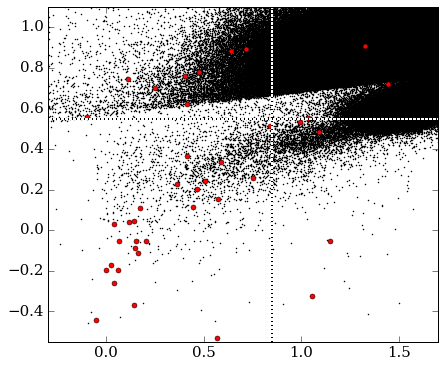

In [109]:
# BOSS GALAXIES
file = SAGA_DIR + '/data/cmass_full.fits'
cmass = Table.read(file)
c_gr = cmass['gmag']-cmass['rmag']
c_ri = cmass['rmag']-cmass['imag']

m1 = cmass['Column1'] == 0
m2 = cmass['zerr'] !=0
m3 = (cmass['rmag'] > 17.7) & (cmass['rmag'] < 21)
m4 = cmass['z'] > 0.005 # no stars!

mlowz = cmass['z'] < 0.015

boss = cmass['z'][m1&m2&m3&m4]

c_gr = cmass['gmag']-cmass['rmag']
c_ri = cmass['rmag']-cmass['imag']

plt.plot(c_gr[m1&m2&m3&m4],c_ri[m1&m2&m3&m4],'ko',ms=1)
plt.plot(c_gr[m1&m2&m3&m4&mlowz],c_ri[m1&m2&m3&m4&mlowz],'ro',ms=5)



xl = [-0.3,1.7]
yl=[-0.55,1.1]
tgr = 0.85
tri = 0.55

mgri = (c_gr > tgr) | (c_ri > tri)
for obj in cmass[m1&m2&m3&m4&mlowz&mgri]:
    print obj['rmag'],obj['ra'],obj['dec']


print 'All CMASS = ',np.sum(m1&m2&m3&m4)
print 'Non-gri in CMASS = ',np.sum(m1&m2&m3&m4&mgri)    

print 'LOWz in CMASS = ',np.sum(m1&m2&m3&m4&mlowz)    
print 'LOWz in CMASS, not passing gri = ',np.sum(m1&m2&m3&m4&mlowz&mgri)


plt.xlim(xl)
plt.ylim(yl)
plt.axvline(tgr, c='w')
plt.axvline(tgr, c='k', ls=':')
plt.axhline(tri, c='w')
plt.axhline(tri, c='k', ls=':')



(array([  1616.,   1877.,   2123.,   2345.,   2525.,   2771.,   2853.,
          2915.,   3112.,   3011.,   3131.,   3231.,   3326.,   3365.,
          3440.,   3380.,   3523.,   3487.,   3579.,   3742.,   3729.,
          3783.,   3861.,   3940.,   3948.,   4184.,   4165.,   4308.,
          4381.,   4573.,   4771.,   4860.,   4991.,   5158.,   5397.,
          5556.,   5718.,   5924.,   6038.,   6177.,   6670.,   6661.,
          6980.,   7033.,   7236.,   7529.,   7674.,   7870.,   8019.,
          8280.,   8411.,   8511.,   8817.,   8802.,   9178.,   9500.,
          9220.,   9615.,   9366.,   8559.,   8114.,   7924.,   8215.,
          8389.,   9201.,   9622.,  10731.,  11493.,  12510.,  13691.,
         14837.,  16097.,  17162.,  18267.,  19493.,  20843.,  21994.,
         23099.,  24054.,  24590.,  25297.,  25941.,  26560.,  26466.,
         26885.,  27211.,  26786.,  27092.,  26559.,  26132.,  25348.,
         25269.,  24913.,  23746.,  22849.,  22086.,  20865.,  19770.,
      

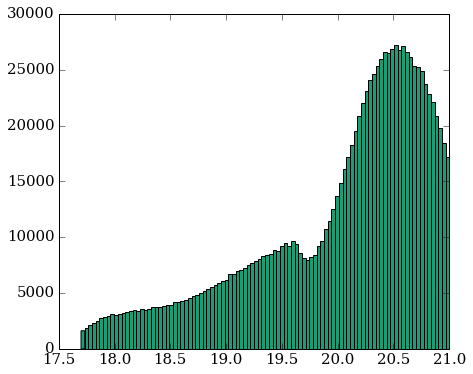

In [110]:
plt.hist(cmass['rmag'][m1&m2&m3&m4],bins=100)


In [111]:
def hist_norm_height(n,bins,const):
    ''' Function to normalise bin height by a constant. 
        Needs n and bins from np.histogram or ax.hist.'''

    n = np.repeat(n,2)
    n = n / const
    new_bins = [bins[0]]
    new_bins.extend(np.repeat(bins[1:],2))

    return n,new_bins[:-1]

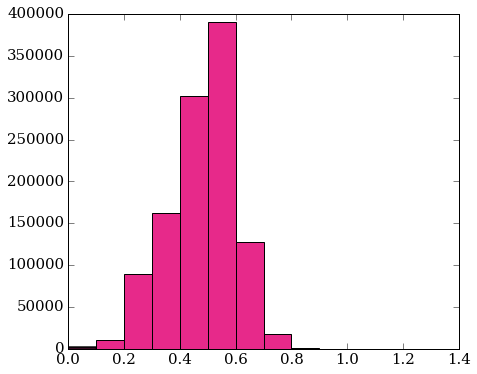

In [112]:
# ALL GALAXIES
n, bins, patches = plt.hist(all['SPEC_Z'], bins = b)
c1 = np.max(n)
nall,new_all = hist_norm_height(n,bins,c1)

# GRI
n, bins, patches = plt.hist(gri['SPEC_Z'], bins = b)
c1 = np.max(n)
ngri,new_gri = hist_norm_height(n,bins,c1)

#UGRI
n, bins, patches = plt.hist(ugri['SPEC_Z'], bins = b)
c = np.max(n)
nugri,new_ugri = hist_norm_height(n,bins,c1)

#BOSS
n, bins, patches = plt.hist(boss, bins = b)
c = np.max(n)
nboss,new_boss = hist_norm_height(n,bins,c)


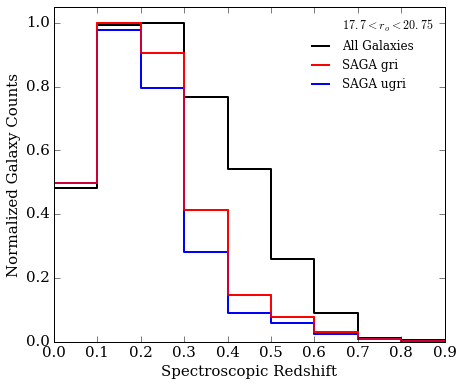

In [113]:

plt.plot([-1],[-1],'.',ms=0,label='$17.7 < r_o < 20.75$')
plt.step(new_all,nall,color='k',label='All Galaxies')
plt.step(new_gri,ngri,color='r',label='SAGA gri')
plt.step(new_ugri,nugri,color='b',label='SAGA ugri')
plt.step(new_gri,ngri,color='r',label='_nolabel_',alpha=0.8)

#plt.step(new_boss,nboss,color='g',label='BOSS')

plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Normalized Galaxy Counts')

plt.xlim(0,0.9)
plt.ylim(0,1.05)

plt.legend(fontsize=12)

plt.savefig('fig_redshift.pdf')
plt.show()


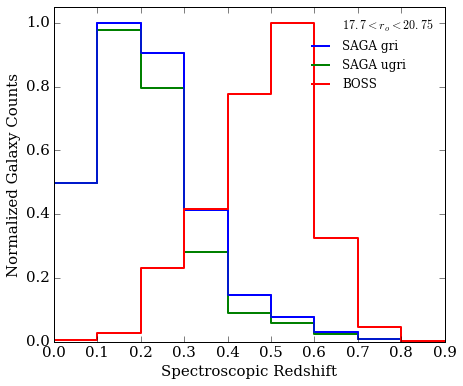

In [114]:
plt.plot([-1],[-1],'.',ms=0,label='$17.7 < r_o < 20.75$')
#plt.step(new_all,nall,color='k',label='All Galaxies')
plt.step(new_gri,ngri,color='b',label='SAGA gri')
plt.step(new_ugri,nugri,color='g',label='SAGA ugri')
plt.step(new_gri,ngri,color='b',label='_nolabel_',alpha=0.8)

plt.step(new_boss,nboss,color='r',label='BOSS')

plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Normalized Galaxy Counts')

plt.xlim(0,0.9)
plt.ylim(0,1.05)

plt.legend(fontsize=12)

#plt.show()
#plt.savefig('fig_redshift.pdf')
